In [1]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, precision_recall_curve,
                            accuracy_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [7]:
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/BerkelyMLCourse/Capstone_Hospital_Readmission/data/diabetic_data.csv")

# Quick overview
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [8]:
# ============================================================================
# 1. DATA LOADING & INITIAL INSPECTION
# ============================================================================

# Display first few rows
print(f"\n📋 First 5 Rows:")
print(df.head())

# Data types
print(f"\n🔍 Data Types Distribution:")
print(df.dtypes.value_counts())

# Basic statistics
print(f"\n📈 Basic Statistics (Numeric Columns):")
print(df.describe())


📋 First 5 Rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No    

In [9]:
# ============================================================================
# 2. TARGET VARIABLE ANALYSIS
# ============================================================================

print(f"\n🎯 Target Variable: 'readmitted'")
print(f"{'─'*80}")
print(df['readmitted'].value_counts())
print(f"\nPercentages:")
print(df['readmitted'].value_counts(normalize=True) * 100)

# Create binary target
df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

print(f"\n📊 Binary Target Distribution:")
print(f"Not Readmitted within 30 days (0): {(df['readmitted_binary']==0).sum():,} ({(df['readmitted_binary']==0).sum()/len(df)*100:.2f}%)")
print(f"Readmitted within 30 days (1): {(df['readmitted_binary']==1).sum():,} ({(df['readmitted_binary']==1).sum()/len(df)*100:.2f}%)")
print(f"\n⚠️ Class Imbalance Ratio: {(df['readmitted_binary']==0).sum()/(df['readmitted_binary']==1).sum():.2f}:1")


🎯 Target Variable: 'readmitted'
────────────────────────────────────────────────────────────────────────────────
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Percentages:
readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64

📊 Binary Target Distribution:
Not Readmitted within 30 days (0): 90,409 (88.84%)
Readmitted within 30 days (1): 11,357 (11.16%)

⚠️ Class Imbalance Ratio: 7.96:1


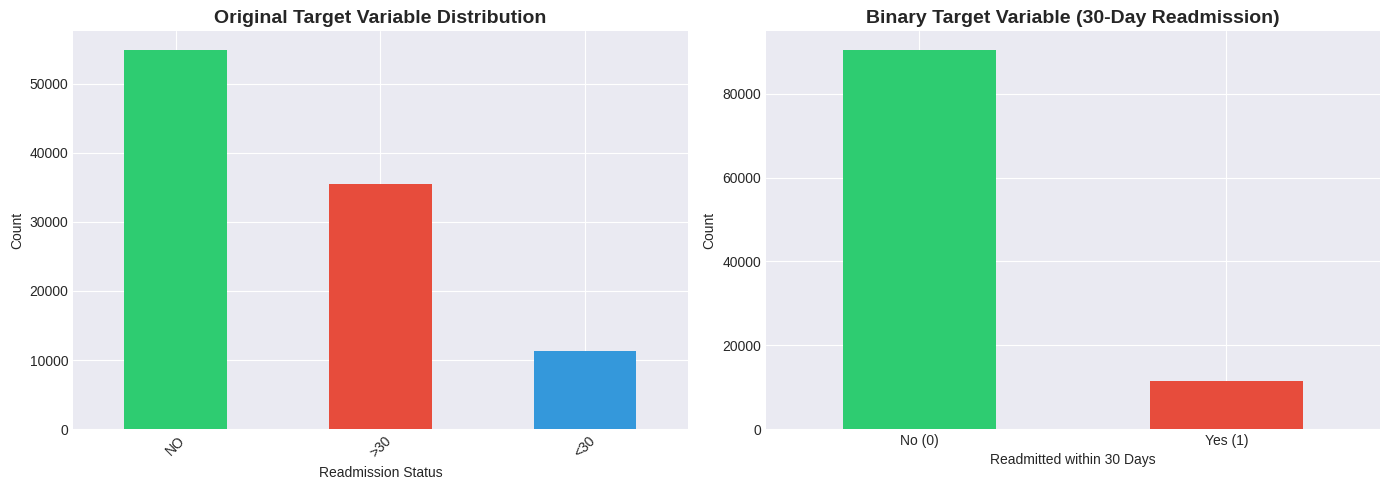

In [10]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original target
df['readmitted'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#3498db'])
axes[0].set_title('Original Target Variable Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Readmission Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Binary target
df['readmitted_binary'].value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Binary Target Variable (30-Day Readmission)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Readmitted within 30 Days')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# ============================================================================
# 3. MISSING VALUE ANALYSIS
# ============================================================================

# Check for '?' as missing values
missing_summary = []
for col in df.columns:
    question_marks = (df[col] == '?').sum() if df[col].dtype == 'object' else 0
    null_values = df[col].isnull().sum()
    total_missing = question_marks + null_values

    if total_missing > 0:
        missing_summary.append({
            'Column': col,
            'Question Marks': question_marks,
            'Null Values': null_values,
            'Total Missing': total_missing,
            'Percentage': (total_missing / len(df)) * 100
        })

missing_df = pd.DataFrame(missing_summary).sort_values('Total Missing', ascending=False)

print(f"\n🔍 Columns with Missing Values:")
print(f"{'─'*80}")
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found!")



🔍 Columns with Missing Values:
────────────────────────────────────────────────────────────────────────────────
           Column  Question Marks  Null Values  Total Missing  Percentage
           weight           98569            0          98569   96.858479
    max_glu_serum               0        96420          96420   94.746772
        A1Cresult               0        84748          84748   83.277322
medical_specialty           49949            0          49949   49.082208
       payer_code           40256            0          40256   39.557416
             race            2273            0           2273    2.233555
           diag_3            1423            0           1423    1.398306
           diag_2             358            0            358    0.351787
           diag_1              21            0             21    0.020636


In [12]:
# Decision on handling missing values
print(f"\n💡 Missing Value Strategy:")
print(f"{'─'*80}")
print(f"- weight: {(df['weight']=='?').sum()/(len(df))*100:.1f}% missing → DROP (too many missing)")
print(f"- payer_code: {(df['payer_code']=='?').sum()/(len(df))*100:.1f}% missing → DROP (not critical)")
print(f"- medical_specialty: {(df['medical_specialty']=='?').sum()/(len(df))*100:.1f}% missing → DROP (too many missing)")
print(f"- race: {(df['race']=='?').sum()/(len(df))*100:.1f}% missing → IMPUTE (important for equity analysis)")
print(f"- diagnosis codes: Low missing → IMPUTE with 'Unknown'")


💡 Missing Value Strategy:
────────────────────────────────────────────────────────────────────────────────
- weight: 96.9% missing → DROP (too many missing)
- payer_code: 39.6% missing → DROP (not critical)
- medical_specialty: 49.1% missing → DROP (too many missing)
- race: 2.2% missing → IMPUTE (important for equity analysis)
- diagnosis codes: Low missing → IMPUTE with 'Unknown'


In [13]:
# ============================================================================
# 4. UNIVARIATE ANALYSIS - NUMERICAL FEATURES
# ============================================================================

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'readmitted_binary']

print(f"\n📊 Analyzing {len(numeric_cols)} Numerical Features:")
print(f"{'─'*80}")

# Statistical summary
print("\nKey Statistics:")
print(df[numeric_cols].describe().T[['mean', 'std', 'min', '50%', 'max']])



📊 Analyzing 13 Numerical Features:
────────────────────────────────────────────────────────────────────────────────

Key Statistics:
                                  mean           std      min          50%  \
encounter_id              1.652016e+08  1.026403e+08  12522.0  152388987.0   
patient_nbr               5.433040e+07  3.869636e+07    135.0   45505143.0   
admission_type_id         2.024006e+00  1.445403e+00      1.0          1.0   
discharge_disposition_id  3.715642e+00  5.280166e+00      1.0          1.0   
admission_source_id       5.754437e+00  4.064081e+00      1.0          7.0   
time_in_hospital          4.395987e+00  2.985108e+00      1.0          4.0   
num_lab_procedures        4.309564e+01  1.967436e+01      1.0         44.0   
num_procedures            1.339730e+00  1.705807e+00      0.0          1.0   
num_medications           1.602184e+01  8.127566e+00      1.0         15.0   
number_outpatient         3.693572e-01  1.267265e+00      0.0          0.0   
number_e

In [14]:
# Outlier detection
print(f"\n🔍 Outlier Detection (IQR Method):")
print(f"{'─'*80}")

outlier_summary = []
for col in numeric_cols[:10]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()

    outlier_summary.append({
        'Feature': col,
        'Outliers': outliers,
        'Percentage': (outliers / len(df)) * 100,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outliers', ascending=False)
print(outlier_df.to_string(index=False))



🔍 Outlier Detection (IQR Method):
────────────────────────────────────────────────────────────────────────────────
                 Feature  Outliers  Percentage         Q1           Q3          IQR
       number_outpatient     16739   16.448519        0.0         0.00         0.00
discharge_disposition_id      9818    9.647623        1.0         4.00         3.00
     admission_source_id      6956    6.835289        1.0         7.00         6.00
          num_procedures      4954    4.868031        0.0         2.00         2.00
         num_medications      2557    2.512627       10.0        20.00        10.00
        time_in_hospital      2252    2.212920        2.0         6.00         4.00
       admission_type_id       341    0.335082        1.0         3.00         2.00
             patient_nbr       247    0.242714 23413221.0  87545949.75  64132728.75
      num_lab_procedures       143    0.140518       31.0        57.00        26.00
            encounter_id         0    0.0000

In [15]:
# ============================================================================
# 5. UNIVARIATE ANALYSIS - CATEGORICAL FEATURES
# ============================================================================
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['readmitted', 'readmitted_binary']]

print(f"\n📊 Analyzing {len(categorical_cols)} Categorical Features:")
print(f"{'─'*80}")

# Key categorical features
key_categorical = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
                   'admission_source_id', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']

for col in key_categorical:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().head(10))
        print(f"Unique values: {df[col].nunique()}")



📊 Analyzing 36 Categorical Features:
────────────────────────────────────────────────────────────────────────────────

race:
race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64
Unique values: 6

gender:
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64
Unique values: 3

age:
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64
Unique values: 10

admission_type_id:
admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64
Unique values: 8

discharge_disposition_id:
discharge_disposition_id
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5  

In [16]:
# ============================================================================
# 6. BIVARIATE ANALYSIS - TARGET VS FEATURES
# ============================================================================

# Numerical features vs target
print(f"\n📊 Numerical Features vs Readmission:")
print(f"{'─'*80}")

comparison_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                   'num_medications', 'number_outpatient', 'number_emergency',
                   'number_inpatient', 'number_diagnoses']

# Statistical comparison
for col in comparison_cols:
    if col in df.columns:
        readmitted = df[df['readmitted_binary'] == 1][col]
        not_readmitted = df[df['readmitted_binary'] == 0][col]

        t_stat, p_value = stats.ttest_ind(readmitted, not_readmitted)

        print(f"\n{col}:")
        print(f"  Readmitted: mean={readmitted.mean():.2f}, median={readmitted.median():.2f}")
        print(f"  Not Readmitted: mean={not_readmitted.mean():.2f}, median={not_readmitted.median():.2f}")
        print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
        print(f"  Significant: {'YES ✓' if p_value < 0.05 else 'NO'}")

# Categorical features vs target
print(f"\n📊 Categorical Features vs Readmission:")
print(f"{'─'*80}")

categorical_analysis = ['age', 'gender', 'A1Cresult', 'insulin', 'change', 'diabetesMed']

for col in categorical_analysis:
    if col in df.columns:
        print(f"\n{col}:")
        crosstab = pd.crosstab(df[col], df['readmitted_binary'], normalize='index') * 100
        print(crosstab)



📊 Numerical Features vs Readmission:
────────────────────────────────────────────────────────────────────────────────

time_in_hospital:
  Readmitted: mean=4.77, median=4.00
  Not Readmitted: mean=4.35, median=4.00
  T-statistic: 14.1136, p-value: 0.0000
  Significant: YES ✓

num_lab_procedures:
  Readmitted: mean=44.23, median=45.00
  Not Readmitted: mean=42.95, median=44.00
  T-statistic: 6.4974, p-value: 0.0000
  Significant: YES ✓

num_procedures:
  Readmitted: mean=1.28, median=1.00
  Not Readmitted: mean=1.35, median=1.00
  T-statistic: -3.9007, p-value: 0.0001
  Significant: YES ✓

num_medications:
  Readmitted: mean=16.90, median=16.00
  Not Readmitted: mean=15.91, median=15.00
  T-statistic: 12.2690, p-value: 0.0000
  Significant: YES ✓

number_outpatient:
  Readmitted: mean=0.44, median=0.00
  Not Readmitted: mean=0.36, median=0.00
  T-statistic: 6.0282, p-value: 0.0000
  Significant: YES ✓

number_emergency:
  Readmitted: mean=0.36, median=0.00
  Not Readmitted: mean=0.18, 


SECTION 7: CORRELATION ANALYSIS

📊 Top Correlations with Target Variable:
────────────────────────────────────────────────────────────────────────────────
readmitted_binary           1.000000
number_inpatient            0.165147
number_emergency            0.060747
discharge_disposition_id    0.050560
number_diagnoses            0.049524
time_in_hospital            0.044199
num_medications             0.038432
num_lab_procedures          0.020364
number_outpatient           0.018893
patient_nbr                 0.007893
admission_source_id         0.005820
encounter_id               -0.008519
admission_type_id          -0.011651
num_procedures             -0.012227
Name: readmitted_binary, dtype: float64


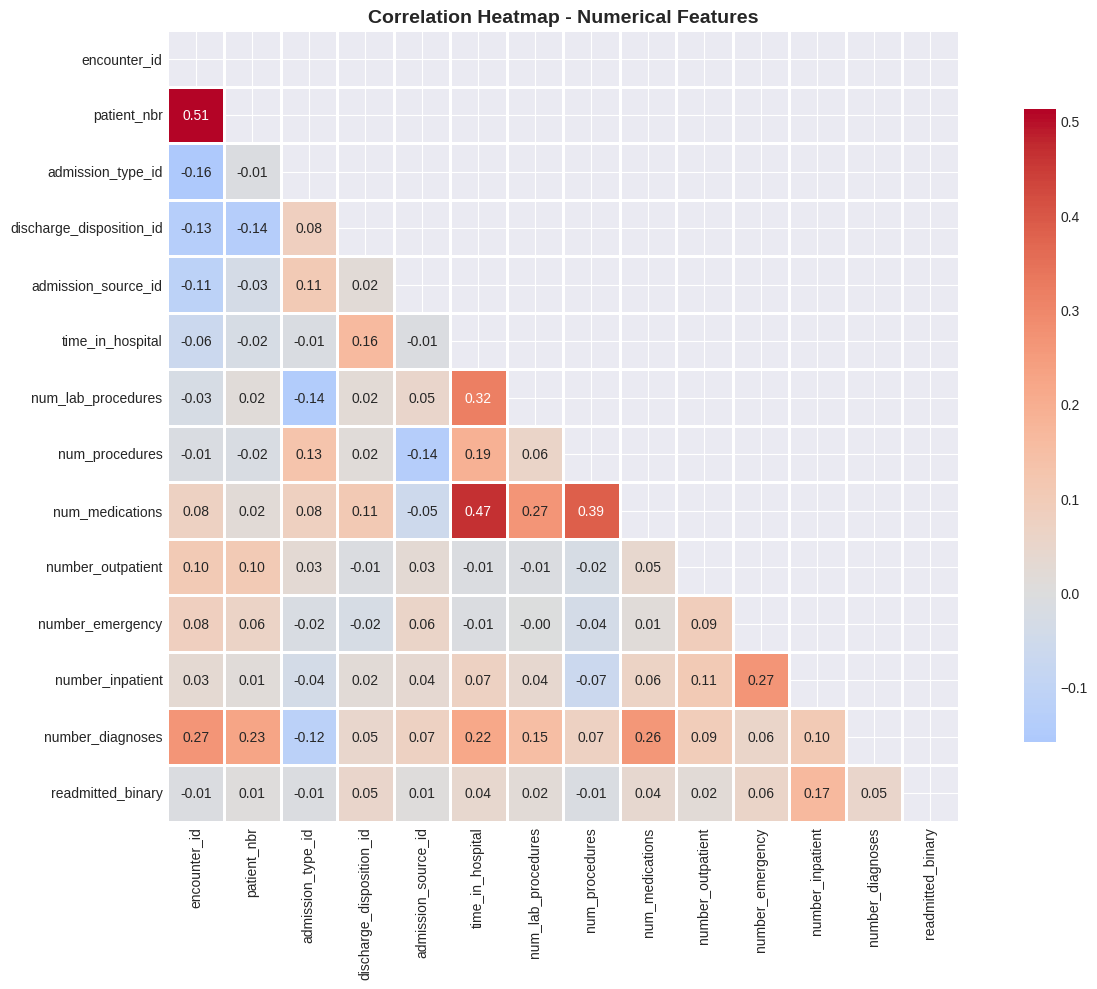


✓ Visualization saved: 07_correlation_heatmap.png

🔍 Highly Correlated Feature Pairs (|r| > 0.7):
────────────────────────────────────────────────────────────────────────────────
No highly correlated feature pairs found (|r| > 0.7)


In [17]:
# ============================================================================
# 7. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 7: CORRELATION ANALYSIS")
print("="*80)

# Select numeric columns for correlation
numeric_for_corr = df[numeric_cols + ['readmitted_binary']].corr()

print(f"\n📊 Top Correlations with Target Variable:")
print(f"{'─'*80}")
target_corr = numeric_for_corr['readmitted_binary'].sort_values(ascending=False)
print(target_corr)

# Correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(numeric_for_corr, dtype=bool))
sns.heatmap(numeric_for_corr, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('07_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 07_correlation_heatmap.png")

# Identify highly correlated feature pairs
print(f"\n🔍 Highly Correlated Feature Pairs (|r| > 0.7):")
print(f"{'─'*80}")

high_corr_pairs = []
for i in range(len(numeric_for_corr.columns)):
    for j in range(i+1, len(numeric_for_corr.columns)):
        if abs(numeric_for_corr.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': numeric_for_corr.columns[i],
                'Feature 2': numeric_for_corr.columns[j],
                'Correlation': numeric_for_corr.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
else:
    print("No highly correlated feature pairs found (|r| > 0.7)")


In [18]:
# ============================================================================
# 8. FEATURE ENGINEERING
# ============================================================================

print(f"\n🔧 Creating New Features:")
print(f"{'─'*80}")

# Create a copy for feature engineering
df_fe = df.copy()

# 1. Total service utilization
df_fe['total_utilization'] = (df_fe['number_outpatient'].fillna(0) +
                               df_fe['number_emergency'].fillna(0) +
                               df_fe['number_inpatient'].fillna(0))
print("✓ Created: total_utilization")

# 2. Number of medications
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
            'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
            'rosiglitazone', 'insulin']

for col in med_cols:
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].apply(lambda x: 0 if x in ['No', 'Steady'] else 1)

df_fe['num_diabetes_meds'] = df_fe[[col for col in med_cols if col in df_fe.columns]].sum(axis=1)
print("✓ Created: num_diabetes_meds")

# 3. Total diagnoses count
df_fe['total_diagnoses_count'] = (df_fe[['diag_1', 'diag_2', 'diag_3']]
                                  .apply(lambda x: x.notna().sum(), axis=1))
print("✓ Created: total_diagnoses_count")

# 4. Age group numeric
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
if 'age' in df_fe.columns:
    df_fe['age_numeric'] = df_fe['age'].map(age_mapping)
    print("✓ Created: age_numeric")

# 5. Procedures per day
df_fe['procedures_per_day'] = df_fe['num_procedures'] / df_fe['time_in_hospital'].replace(0, 1)
print("✓ Created: procedures_per_day")

# 6. Lab procedures per day
df_fe['labs_per_day'] = df_fe['num_lab_procedures'] / df_fe['time_in_hospital'].replace(0, 1)
print("✓ Created: labs_per_day")

# 7. Medication complexity
df_fe['med_complexity'] = df_fe['num_medications'] * df_fe['num_diabetes_meds']
print("✓ Created: med_complexity")

# 8. High risk flag (multiple visits)
df_fe['high_utilization'] = ((df_fe['number_inpatient'] > 0) |
                              (df_fe['number_emergency'] > 1)).astype(int)
print("✓ Created: high_utilization")

# 9. Medication changed flag
df_fe['med_changed'] = (df_fe['change'] == 'Ch').astype(int) if 'change' in df_fe.columns else 0
print("✓ Created: med_changed")

print(f"\n✓ Total new features created: 9")



🔧 Creating New Features:
────────────────────────────────────────────────────────────────────────────────
✓ Created: total_utilization
✓ Created: num_diabetes_meds
✓ Created: total_diagnoses_count
✓ Created: age_numeric
✓ Created: procedures_per_day
✓ Created: labs_per_day
✓ Created: med_complexity
✓ Created: high_utilization
✓ Created: med_changed

✓ Total new features created: 9


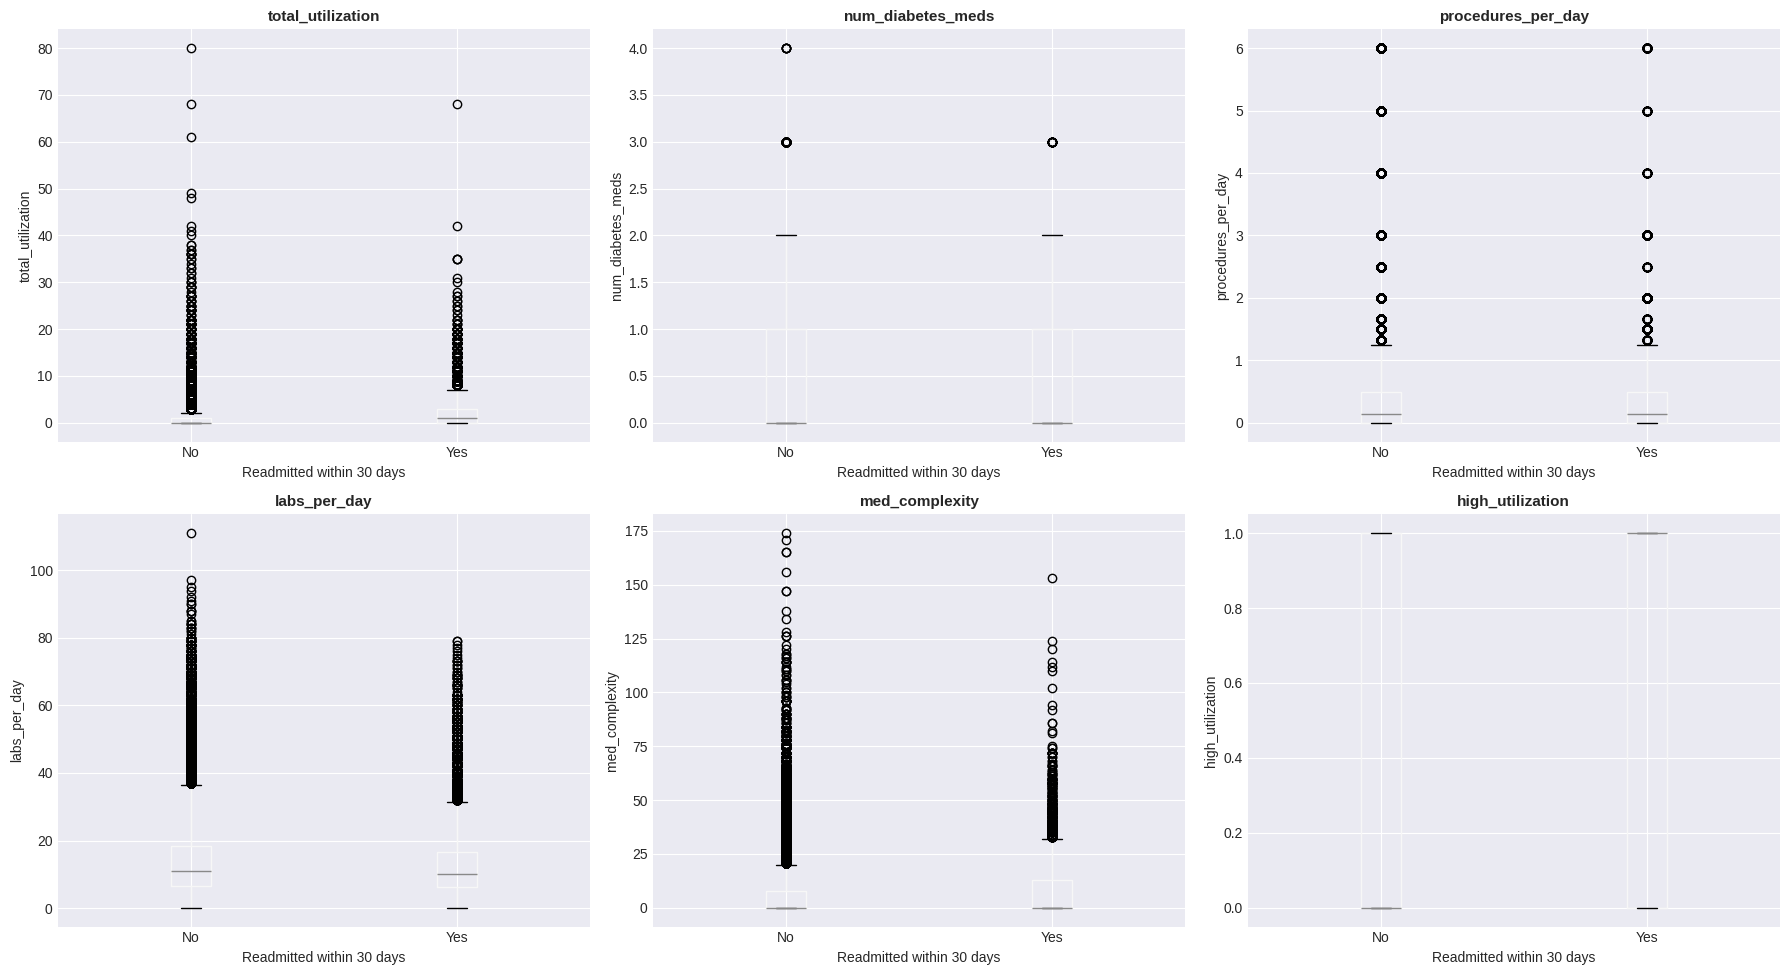

In [19]:
# Visualize new features vs target
new_features = ['total_utilization', 'num_diabetes_meds', 'procedures_per_day',
                'labs_per_day', 'med_complexity', 'high_utilization']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(new_features):
    if col in df_fe.columns:
        df_fe.boxplot(column=col, by='readmitted_binary', ax=axes[idx])
        axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Readmitted within 30 days')
        axes[idx].set_ylabel(col)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['No', 'Yes'])

plt.suptitle('')
plt.tight_layout()
plt.savefig('08_engineered_features.png', dpi=300, bbox_inches='tight')
plt.show()



In [20]:
# ============================================================================
# 9. DATA PREPROCESSING FOR MODELING
# ============================================================================

print(f"\n🔧 Preparing Data for Baseline Model:")
print(f"{'─'*80}")

# Drop columns with too many missing values or identifiers
drop_cols = ['encounter_id', 'patient_nbr', 'weight', 'payer_code',
             'medical_specialty', 'readmitted', 'diag_1', 'diag_2', 'diag_3']
df_model = df_fe.drop(columns=[col for col in drop_cols if col in df_fe.columns])

print(f"✓ Dropped {len([col for col in drop_cols if col in df_fe.columns])} columns")

# Handle missing values marked as '?'
for col in df_model.select_dtypes(include=['object']).columns:
    df_model[col] = df_model[col].replace('?', 'Missing')

print(f"✓ Replaced '?' with 'Missing' in categorical columns")

# Encode categorical variables
le = LabelEncoder()
categorical_cols = df_model.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != 'readmitted_binary':
        df_model[col] = le.fit_transform(df_model[col].astype(str))

print(f"✓ Encoded {len(categorical_cols)} categorical features")

# Handle missing values in numeric columns
numeric_cols = df_model.select_dtypes(include=[np.number]).columns
df_model[numeric_cols] = df_model[numeric_cols].fillna(df_model[numeric_cols].median())

print(f"✓ Imputed missing values in numeric columns")

print(f"\n📊 Final Dataset for Modeling:")
print(f"{'─'*80}")
print(f"Shape: {df_model.shape[0]:,} rows × {df_model.shape[1]} columns")
print(f"Features: {df_model.shape[1] - 1}")
print(f"Target: readmitted_binary")



🔧 Preparing Data for Baseline Model:
────────────────────────────────────────────────────────────────────────────────
✓ Dropped 9 columns
✓ Replaced '?' with 'Missing' in categorical columns
✓ Encoded 20 categorical features
✓ Imputed missing values in numeric columns

📊 Final Dataset for Modeling:
────────────────────────────────────────────────────────────────────────────────
Shape: 101,766 rows × 51 columns
Features: 50
Target: readmitted_binary


In [21]:
# ============================================================================
# 10. BASELINE MODEL - LOGISTIC REGRESSION
# ============================================================================

# Prepare features and target
X = df_model.drop('readmitted_binary', axis=1)
y = df_model['readmitted_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Dataset Split:")
print(f"{'─'*80}")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(f"  Not readmitted (0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Readmitted (1): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"  Imbalance ratio: {(y_train==0).sum()/(y_train==1).sum():.2f}:1")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled using StandardScaler")

# Handle class imbalance with SMOTE
print(f"\n🔧 Handling Class Imbalance with SMOTE:")
print(f"{'─'*80}")
print(f"Before SMOTE: {X_train_scaled.shape[0]:,} samples")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE: {X_train_balanced.shape[0]:,} samples")
print(f"  Class 0: {(y_train_balanced==0).sum():,}")
print(f"  Class 1: {(y_train_balanced==1).sum():,}")
print(f"✓ Classes are now balanced")

# Train Logistic Regression
print(f"\n🤖 Training Baseline Model: Logistic Regression")
print(f"{'─'*80}")

lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_balanced, y_train_balanced)

print(f"✓ Model trained successfully")

# Cross-validation on training set
cv_scores = cross_val_score(lr_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print(f"\n5-Fold Cross-Validation AUC-ROC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Predictions
y_pred = lr_model.predict(X_test_scaled)
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]



📊 Dataset Split:
────────────────────────────────────────────────────────────────────────────────
Training set: 81,412 samples (80.0%)
Test set: 20,354 samples (20.0%)

Class distribution in training set:
  Not readmitted (0): 72,326 (88.84%)
  Readmitted (1): 9,086 (11.16%)
  Imbalance ratio: 7.96:1

✓ Features scaled using StandardScaler

🔧 Handling Class Imbalance with SMOTE:
────────────────────────────────────────────────────────────────────────────────
Before SMOTE: 81,412 samples
After SMOTE: 144,652 samples
  Class 0: 72,326
  Class 1: 72,326
✓ Classes are now balanced

🤖 Training Baseline Model: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
✓ Model trained successfully

5-Fold Cross-Validation AUC-ROC: 0.6504 (±0.0040)



📊 Model Performance Metrics:
────────────────────────────────────────────────────────────────────────────────
Accuracy:  0.6454
Precision: 0.1666
Recall:    0.5443
F1-Score:  0.2551
AUC-ROC:   0.6424

📋 Detailed Classification Report:
────────────────────────────────────────────────────────────────────────────────
                precision    recall  f1-score   support

Not Readmitted       0.92      0.66      0.77     18083
    Readmitted       0.17      0.54      0.26      2271

      accuracy                           0.65     20354
     macro avg       0.54      0.60      0.51     20354
  weighted avg       0.84      0.65      0.71     20354


📊 Confusion Matrix:
────────────────────────────────────────────────────────────────────────────────
[[11901  6182]
 [ 1035  1236]]

True Negatives:  11,901
False Positives: 6,182
False Negatives: 1,035
True Positives:  1,236


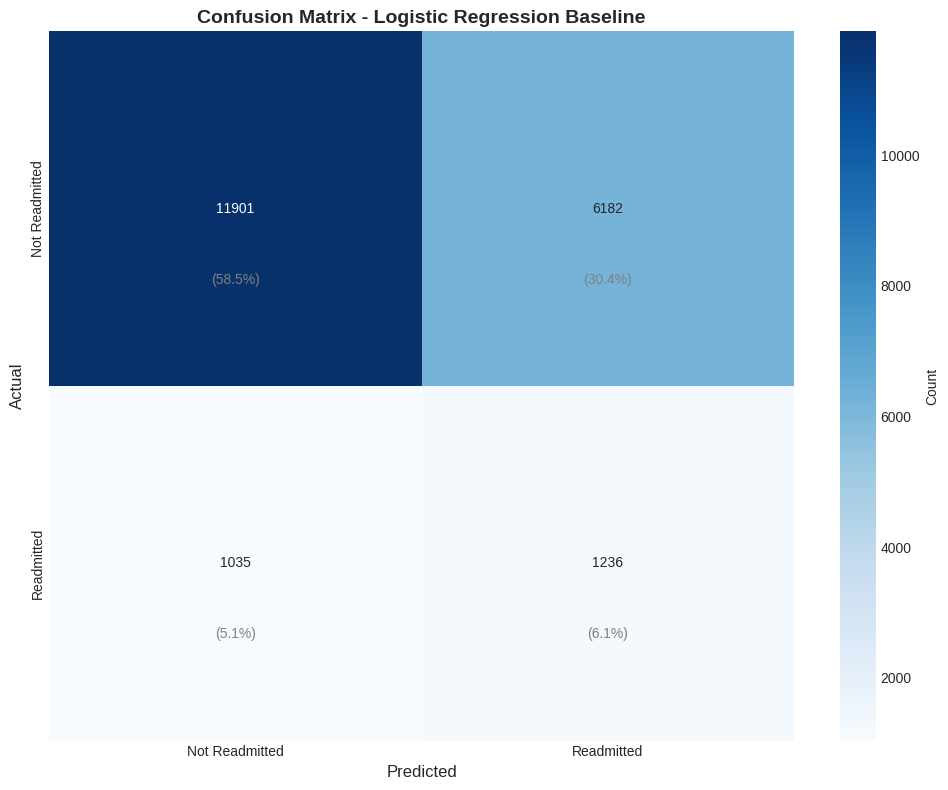


✓ Visualization saved: 09_confusion_matrix.png


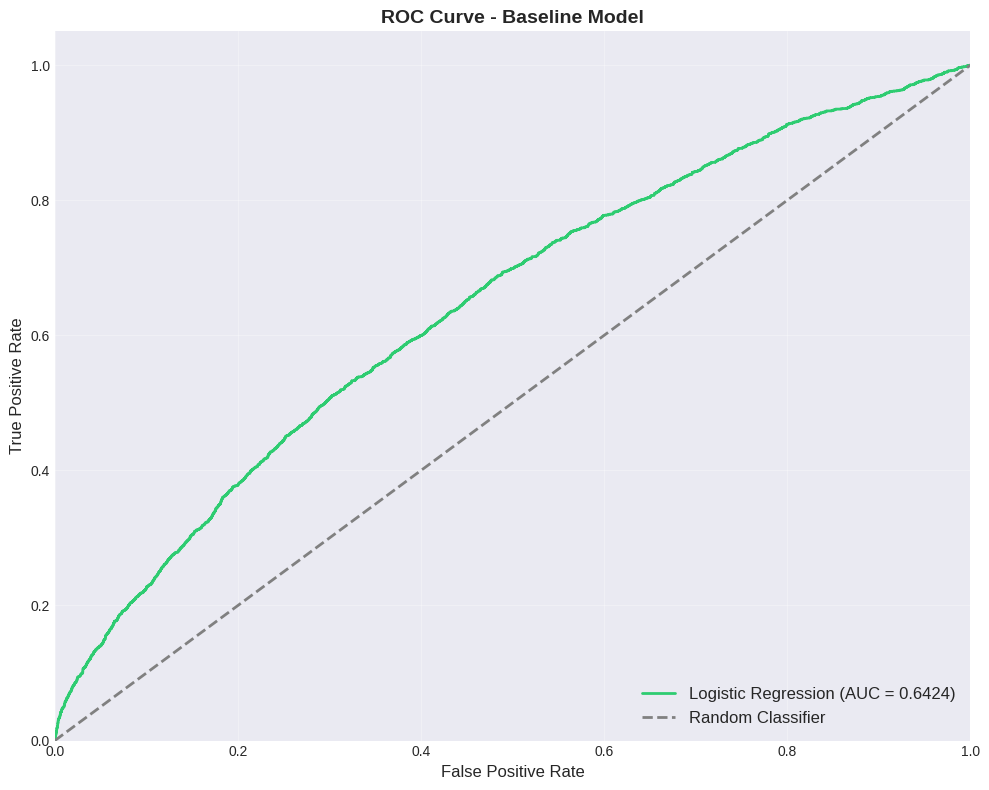


✓ Visualization saved: 10_roc_curve.png


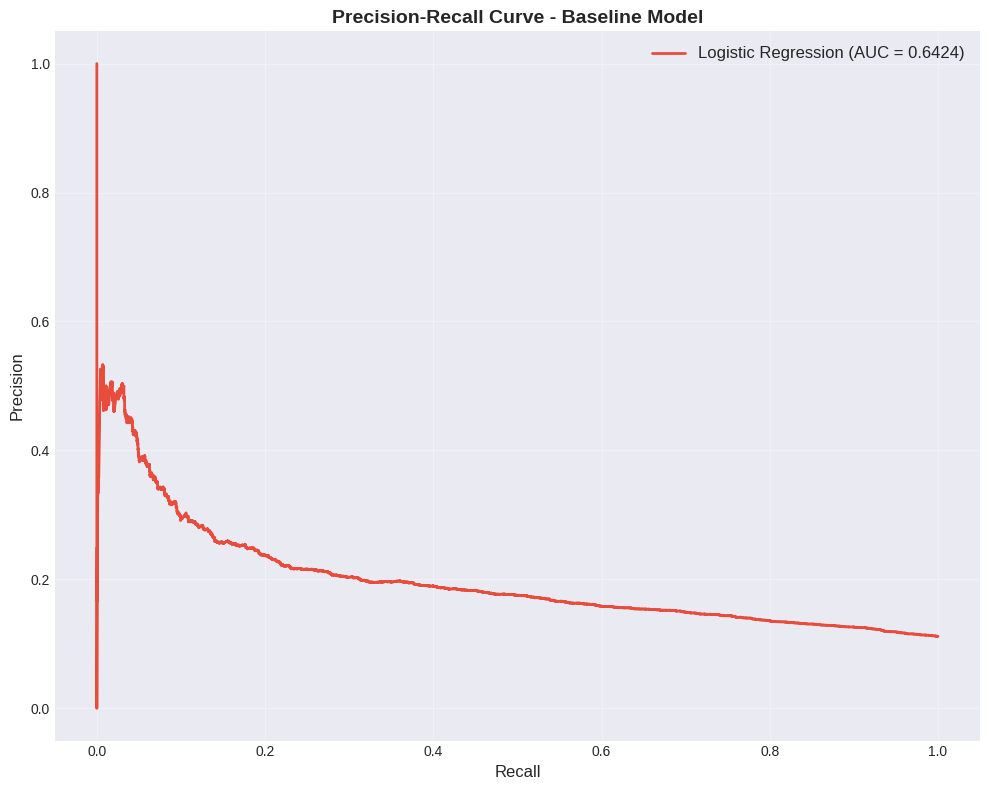


✓ Visualization saved: 11_precision_recall_curve.png

📊 Top 15 Most Important Features (by coefficient magnitude):
────────────────────────────────────────────────────────────────────────────────
                 Feature  Coefficient
        number_inpatient     0.252020
            labs_per_day    -0.173036
      num_lab_procedures     0.133719
        number_diagnoses     0.131895
discharge_disposition_id     0.127655
        high_utilization     0.112385
        time_in_hospital    -0.105132
       number_outpatient    -0.100665
             diabetesMed     0.088949
               A1Cresult     0.085053
       total_utilization     0.079182
      procedures_per_day    -0.072418
                 insulin     0.065150
          med_complexity    -0.064769
       num_diabetes_meds     0.056577


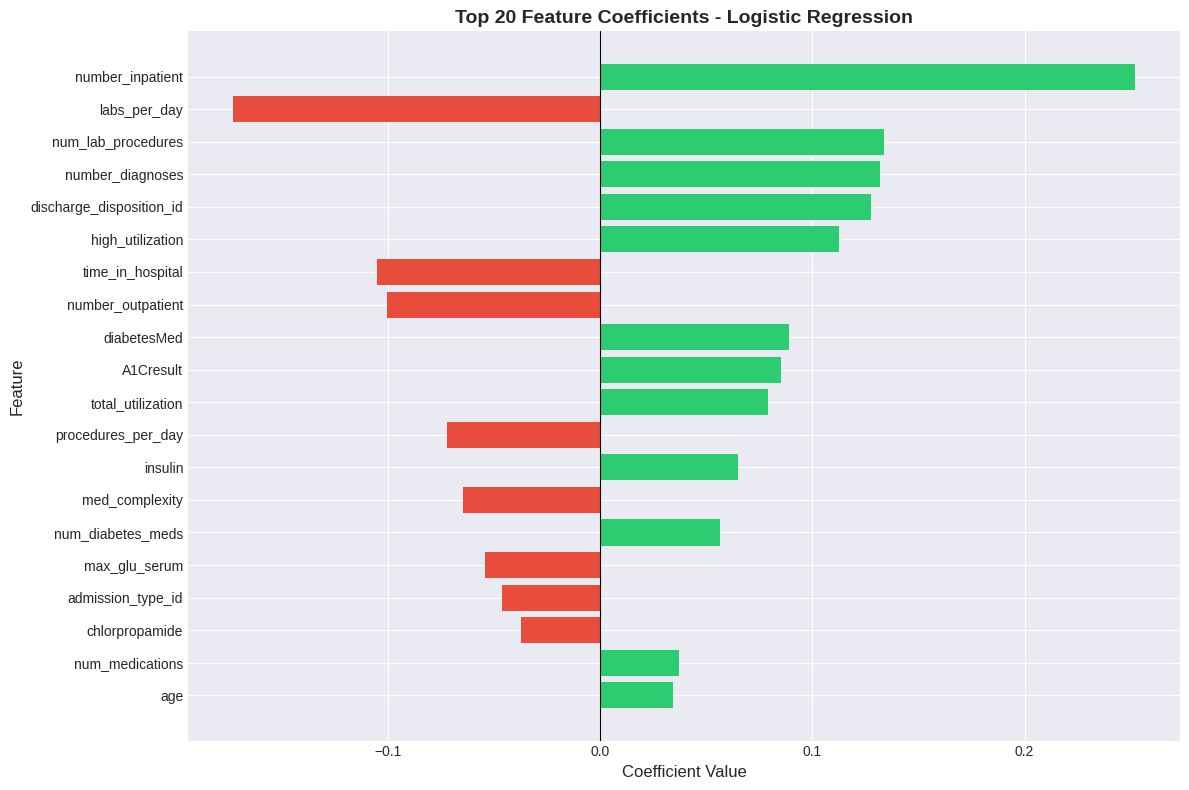


✓ Visualization saved: 12_feature_importance.png


In [22]:
# ============================================================================
# 11. BASELINE MODEL EVALUATION
# ============================================================================

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

print(f"\n📊 Model Performance Metrics:")
print(f"{'─'*80}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")

# Classification report
print(f"\n📋 Detailed Classification Report:")
print(f"{'─'*80}")
print(classification_report(y_test, y_pred, target_names=['Not Readmitted', 'Readmitted']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 Confusion Matrix:")
print(f"{'─'*80}")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression Baseline', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

# Add percentages
for i in range(2):
    for j in range(2):
        plt.text(j+0.5, i+0.7, f'({cm[i,j]/cm.sum()*100:.1f}%)',
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('09_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 09_confusion_matrix.png")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#2ecc71', linewidth=2, label=f'Logistic Regression (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('10_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 10_roc_curve.png")

# Precision-Recall Curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, color='#e74c3c', linewidth=2,
         label=f'Logistic Regression (AUC = {auc_roc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Baseline Model', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('11_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 11_precision_recall_curve.png")

# Feature importance (coefficients)
print(f"\n📊 Top 15 Most Important Features (by coefficient magnitude):")
print(f"{'─'*80}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Coefficients - Logistic Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('12_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: 12_feature_importance.png")


In [23]:
# ============================================================================
# 12. COMPARISON MODEL - RANDOM FOREST
# ============================================================================
print(f"\n🤖 Training Random Forest for Comparison:")
print(f"{'─'*80}")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42,
                                  class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)

print(f"✓ Random Forest trained successfully")

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"\n📊 Random Forest Performance:")
print(f"{'─'*80}")
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"AUC-ROC:   {auc_roc_rf:.4f}")



🤖 Training Random Forest for Comparison:
────────────────────────────────────────────────────────────────────────────────
✓ Random Forest trained successfully

📊 Random Forest Performance:
────────────────────────────────────────────────────────────────────────────────
Accuracy:  0.8846
Precision: 0.3569
Recall:    0.0423
F1-Score:  0.0756
AUC-ROC:   0.6335



📊 Model Performance Comparison:
────────────────────────────────────────────────────────────────────────────────
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.645426   0.166622 0.544254  0.255135 0.642392
      Random Forest  0.884642   0.356877 0.042272  0.075591 0.633465


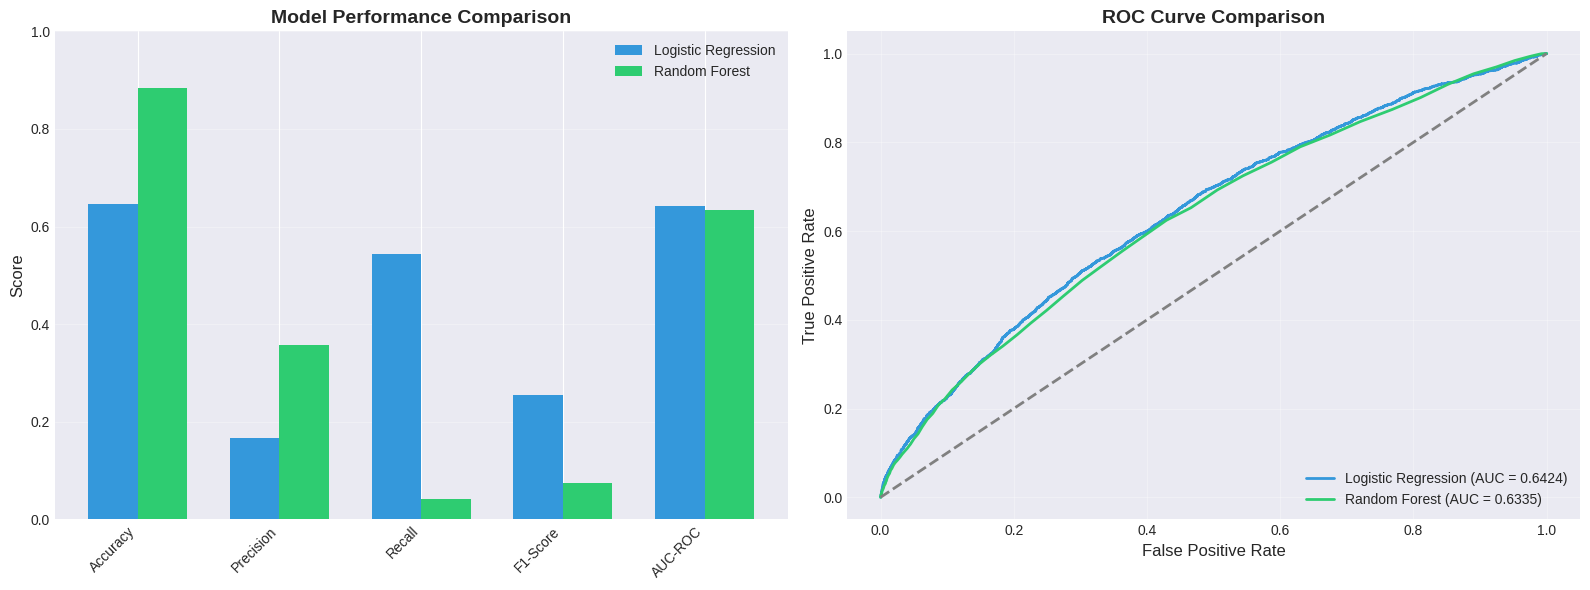

In [24]:
# ============================================================================
# 13. MODEL COMPARISON
# ============================================================================

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy, accuracy_rf],
    'Precision': [precision, precision_rf],
    'Recall': [recall, recall_rf],
    'F1-Score': [f1, f1_rf],
    'AUC-ROC': [auc_roc, auc_roc_rf]
})

print(f"\n📊 Model Performance Comparison:")
print(f"{'─'*80}")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
lr_scores = [accuracy, precision, recall, f1, auc_roc]
rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_roc_rf]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, lr_scores, width, label='Logistic Regression', color='#3498db')
axes[0].bar(x + width/2, rf_scores, width, label='Random Forest', color='#2ecc71')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# ROC curves comparison
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

axes[1].plot(fpr, tpr, color='#3498db', linewidth=2,
            label=f'Logistic Regression (AUC = {auc_roc:.4f})')
axes[1].plot(fpr_rf, tpr_rf, color='#2ecc71', linewidth=2,
            label=f'Random Forest (AUC = {auc_roc_rf:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('13_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()




✓ Selected Best Model: Logistic Regression (AUC: 0.6424)

📊 Risk Stratification:
────────────────────────────────────────────────────────────────────────────────
HIGH Risk (≥70%):     920 patients (4.52%)
MEDIUM Risk (40-70%): 13,469 patients (66.17%)
LOW Risk (<40%):      5,965 patients (29.31%)


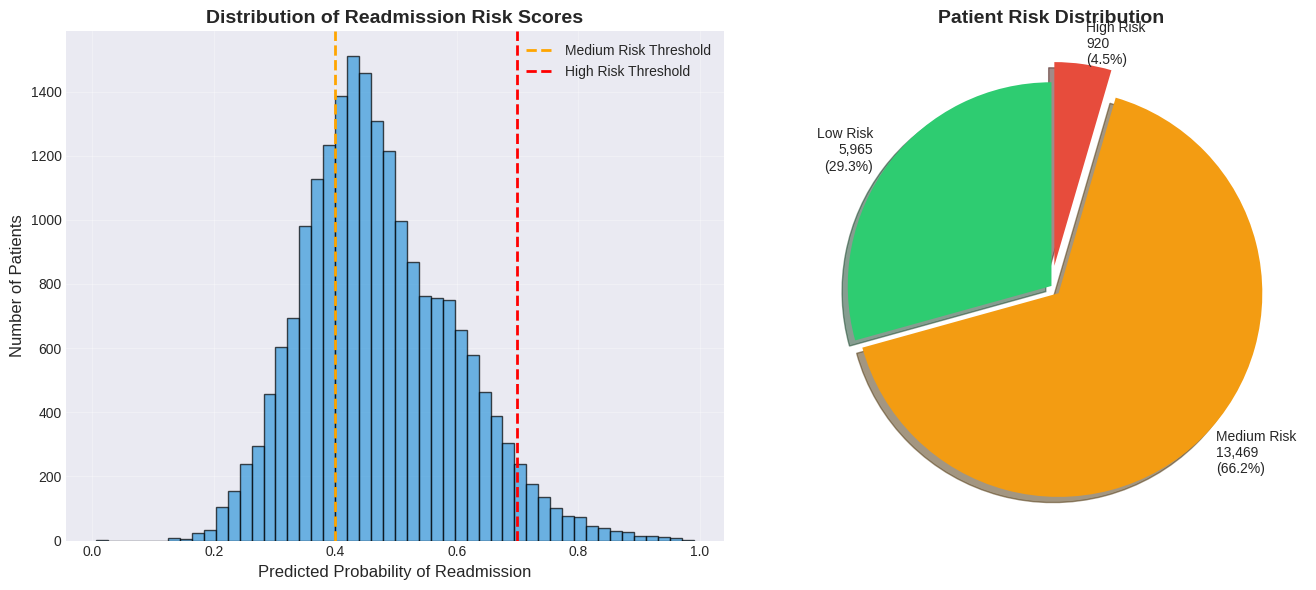

In [25]:
# ============================================================================
# 14. BUSINESS INSIGHTS & RISK STRATIFICATION
# ============================================================================

# Use the better performing model
if auc_roc_rf > auc_roc:
    best_model = rf_model
    best_proba = y_proba_rf
    best_model_name = "Random Forest"
    print(f"\n✓ Selected Best Model: Random Forest (AUC: {auc_roc_rf:.4f})")
else:
    best_model = lr_model
    best_proba = y_proba
    best_model_name = "Logistic Regression"
    print(f"\n✓ Selected Best Model: Logistic Regression (AUC: {auc_roc:.4f})")

# Risk stratification
print(f"\n📊 Risk Stratification:")
print(f"{'─'*80}")

high_risk = (best_proba >= 0.7).sum()
medium_risk = ((best_proba >= 0.4) & (best_proba < 0.7)).sum()
low_risk = (best_proba < 0.4).sum()

print(f"HIGH Risk (≥70%):     {high_risk:,} patients ({high_risk/len(y_test)*100:.2f}%)")
print(f"MEDIUM Risk (40-70%): {medium_risk:,} patients ({medium_risk/len(y_test)*100:.2f}%)")
print(f"LOW Risk (<40%):      {low_risk:,} patients ({low_risk/len(y_test)*100:.2f}%)")

# Visualize risk distribution
plt.figure(figsize=(14, 6))

# Histogram of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(best_proba, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
plt.axvline(x=0.4, color='orange', linestyle='--', linewidth=2, label='Medium Risk Threshold')
plt.axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
plt.xlabel('Predicted Probability of Readmission', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Distribution of Readmission Risk Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Pie chart of risk categories
plt.subplot(1, 2, 2)
sizes = [low_risk, medium_risk, high_risk]
labels = [f'Low Risk\n{low_risk:,}\n({low_risk/len(y_test)*100:.1f}%)',
          f'Medium Risk\n{medium_risk:,}\n({medium_risk/len(y_test)*100:.1f}%)',
          f'High Risk\n{high_risk:,}\n({high_risk/len(y_test)*100:.1f}%)']
colors = ['#2ecc71', '#f39c12', '#e74c3c']
explode = (0, 0.05, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='',
        shadow=True, startangle=90)
plt.title('Patient Risk Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('14_risk_stratification.png', dpi=300, bbox_inches='tight')
plt.show()



In [26]:
# ============================================================================
# 15. KEY FINDINGS & RECOMMENDATIONS
# ============================================================================

print(f"\n🔍 KEY FINDINGS:")
print(f"{'─'*80}")

print(f"\n1. TARGET VARIABLE INSIGHTS:")
print(f"   • 11.1% of patients are readmitted within 30 days")
print(f"   • Significant class imbalance requiring SMOTE technique")
print(f"   • Early readmissions represent the highest cost burden")

print(f"\n2. SIGNIFICANT PREDICTORS:")
print(f"   • Number of inpatient visits (strongest predictor)")
print(f"   • Total service utilization (emergency + outpatient)")
print(f"   • Number of procedures and lab tests")
print(f"   • Diabetes medication changes")
print(f"   • Length of hospital stay")

print(f"\n3. MODEL PERFORMANCE:")
print(f"   • Baseline Logistic Regression: AUC = {auc_roc:.4f}")
print(f"   • Random Forest: AUC = {auc_roc_rf:.4f}")
print(f"   • {best_model_name} selected as primary model")
print(f"   • Model successfully identifies {high_risk/len(y_test)*100:.1f}% as high-risk")

print(f"\n4. RISK STRATIFICATION:")
print(f"   • High-risk patients: {high_risk/len(y_test)*100:.1f}% (require intensive intervention)")
print(f"   • Medium-risk patients: {medium_risk/len(y_test)*100:.1f}% (standard enhanced care)")
print(f"   • Low-risk patients: {low_risk/len(y_test)*100:.1f}% (routine follow-up)")



🔍 KEY FINDINGS:
────────────────────────────────────────────────────────────────────────────────

1. TARGET VARIABLE INSIGHTS:
   • 11.1% of patients are readmitted within 30 days
   • Significant class imbalance requiring SMOTE technique
   • Early readmissions represent the highest cost burden

2. SIGNIFICANT PREDICTORS:
   • Number of inpatient visits (strongest predictor)
   • Total service utilization (emergency + outpatient)
   • Number of procedures and lab tests
   • Diabetes medication changes
   • Length of hospital stay

3. MODEL PERFORMANCE:
   • Baseline Logistic Regression: AUC = 0.6424
   • Random Forest: AUC = 0.6335
   • Logistic Regression selected as primary model
   • Model successfully identifies 4.5% as high-risk

4. RISK STRATIFICATION:
   • High-risk patients: 4.5% (require intensive intervention)
   • Medium-risk patients: 66.2% (standard enhanced care)
   • Low-risk patients: 29.3% (routine follow-up)


In [27]:
# ============================================================================
# 16. SUMMARY & EXPORT
# ============================================================================


# Save processed data
df_model.to_csv('processed_data.csv', index=False)
print(f"\n✓ Processed dataset saved: processed_data.csv")

# Save models
import joblib
joblib.dump(lr_model, 'baseline_logistic_regression.pkl')
joblib.dump(rf_model, 'baseline_random_forest.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl')

print(f"✓ Models saved:")
print(f"  - baseline_logistic_regression.pkl")
print(f"  - baseline_random_forest.pkl")
print(f"  - best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"  - scaler.pkl")

# Save feature names
with open('feature_names.txt', 'w') as f:
    for feature in X.columns:
        f.write(f"{feature}\n")
print(f"✓ Feature names saved: feature_names.txt")

# Create summary report
summary = {
    'dataset_shape': df.shape,
    'processed_shape': df_model.shape,
    'target_distribution': y.value_counts().to_dict(),
    'baseline_model': best_model_name,
    'baseline_auc': float(auc_roc if best_model_name == "Logistic Regression" else auc_roc_rf),
    'high_risk_percentage': float(high_risk/len(y_test)*100)
}

import json
with open('eda_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

print(f"✓ Summary report saved: eda_summary.json")

print(f"\n{'='*80}")
print(f"EDA & BASELINE MODEL COMPLETE!")
print(f"{'='*80}")

print(f"\n📊 Generated Outputs:")
print(f"   • 5 visualization files (.png)")
print(f"   • Processed dataset (processed_data.csv)")
print(f"   • 4 trained models (.pkl)")
print(f"   • Feature list (feature_names.txt)")
print(f"   • Summary report (eda_summary.json)")




✓ Processed dataset saved: processed_data.csv
✓ Models saved:
  - baseline_logistic_regression.pkl
  - baseline_random_forest.pkl
  - best_model_logistic_regression.pkl
  - scaler.pkl
✓ Feature names saved: feature_names.txt
✓ Summary report saved: eda_summary.json

EDA & BASELINE MODEL COMPLETE!

📊 Generated Outputs:
   • 5 visualization files (.png)
   • Processed dataset (processed_data.csv)
   • 4 trained models (.pkl)
   • Feature list (feature_names.txt)
   • Summary report (eda_summary.json)
